\hfill Department of Statistics

\hfill Jaeyeong Kim, Alex Ruiz

## Define Functions

In [1]:
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import pandas as pd

def softmax(x):
    return np.divide(x, np.sum(np.exp(-np.float32(x)), axis = 1, keepdims = True))

def score(X_train, X_valid, Y_train, Y_valid, w):
    #get shapes of the train and the validation data sets
    m,   n = X_train.shape
    m1, n1 = X_valid.shape
    a, b = Y_train.shape

    
    #save prediction of Y
    Y_predict_train = np.zeros((m,b))
    Y_predict_valid = np.zeros((m1,b))
        
    # predict Y of the train set and the test set
    h_train = softmax(np.dot(X_train, w))
    h_valid = softmax(np.dot(X_valid, w))
    
    for i in range(m):
        Y_predict_train[i, np.argmax(h_train[i])] = 1
    for i in range(m1):
        Y_predict_valid[i, np.argmax(h_valid[i])] = 1
    
    score_train = 0
    score_valid = 0
    for i in range(m):
        if np.argmax(Y_train[i]) == np.argmax(Y_predict_train[i]):
            score_train += 1
    for i in range(m1):
        if np.argmax(Y_valid[i]) == np.argmax(Y_predict_valid[i]):
            score_valid += 1

    return score_train/m, score_valid/m1


def fsa(X_train, X_valid, Y_train, Y_valid, \
                        learning_rate, s, iteration, eta0, k, print_loss):
    #get shapes of the train and the validation data sets
    m, n = X_train.shape
    m1,n1 = X_valid.shape
    a, b = Y_train.shape

    #set w0 = 0
    w = np.zeros((n,b))
    loss = []
    
    for i in range(iteration):
        xb = np.dot(X_train,w)
        yxb = np.multiply(Y_train, xb)
        
        #make dummy function (if yxb<=1 then I = 1, else I = 0)
        I = np.copy(yxb)
        I[yxb<=1] = 1
        I[yxb>1] = 0
        
        #calculate losses
        if print_loss == True:
           
            loss1 = 1/m * np.sum(np.multiply(I, \
                np.log(np.float32(1+np.power(yxb-1,2))))) \
            + s * np.sum(np.dot(w[1:].T, w[1:]))
            loss.append([i+1, loss1])        

        #update w
        numerator = np.multiply(I, 2 * np.multiply(Y_train,(yxb-1)))
        denominator = (1 + np.power((yxb-1),2))
        grad = np.dot(X_train.T, np.divide(numerator, denominator)) + 2 * s * m * w
        w = w - learning_rate / m * grad
        #w[1:] = w[1:]*(1-s*eta0)

        #feature selection
        if w.shape[0] > k:
            w1 = np.linalg.norm(np.float32(w), axis=1)
            sb = w1[np.argsort(-abs(w1))]
            M = k + int((n-k) * max(0, (iteration - 2*(i+1))/\
                                    (2*(i+1)*eta0 + iteration)))
            if w.shape[0] > M:
                j = np.where(np.abs(w1) >= abs(sb[M-1]))
                X_train = np.where(np.abs(w1) >= abs(sb[M-1]), X_train, None)
                X_train = pd.DataFrame(X_train)
                X_train = np.array(X_train.dropna(axis = 1))
                
                X_valid = np.where(np.abs(w1) >= abs(sb[M-1]), X_valid, None)
                X_valid = pd.DataFrame(X_valid)
                X_valid = np.array(X_valid.dropna(axis = 1))
                
                w = w[j]

            else:
                continue
        else:
            continue
        
  
    score_train, score_valid = score(X_train, \
                                X_valid, Y_train, Y_valid, w)
    error_result = [k, 1-score_train, 1-score_valid]
    
    return error_result, loss

## preprocessing

In [ ]:
import numpy as np
import pandas as pd

# Reading a dataset
X = pd.read_csv('Covtype\covtype.data', header = None)

#split a dataset
train = X[:15120]
test = X[15120:]
m, n = X.shape

X_train = train.loc[:,:n-2]
Y_train = train.loc[:,n-1]
X_test = test.loc[:,:n-2]
Y_test = test.loc[:,n-1]

#one hot encoding
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

#make csv files
X_train.to_csv('Covtype\X_train.csv', index = False, header = False)
Y_train.to_csv('Covtype\Y_train.csv', index = False, header = False)
X_test.to_csv('Covtype\X_test.csv', index = False, header = False)
Y_test.to_csv('Covtype\Y_test.csv', index = False, header = False)




# Reading a dataset
X_train = pd.read_csv('satimage\X.dat', header = None, delimiter = ' ')
Y_train = pd.read_csv('satimage\Y.dat', header = None)[0]
X_test = pd.read_csv('satimage\Xtest.dat', header = None, delimiter = ' ')
Y_test = pd.read_csv('satimage\Ytest.dat', header = None)[0]

#one hot encoding
Y_train = pd.get_dummies(Y_train)
Y_test = pd.get_dummies(Y_test)

#make csv files
X_train.to_csv('satimage\X_train.csv', index = False, header = False)
Y_train.to_csv('satimage\Y_train.csv', index = False, header = False)
X_test.to_csv('satimage\X_test.csv', index = False, header = False)
Y_test.to_csv('satimage\Y_test.csv', index = False, header = False)

# satimage

In [2]:
# Reading in the gisette data set
X_train = pd.read_csv('satimage\X_train.csv', header = None)
Y_train = pd.read_csv('satimage\Y_train.csv', header = None)

X_test = pd.read_csv('satimage\X_test.csv', header = None)
Y_test = pd.read_csv('satimage\Y_test.csv', header = None)

ks = np.array([5, 9, 18, 27, 36])
error_results = np.array(np.zeros((ks.size,3)))
ws = np.array(np.zeros((ks.size,2)))

m,n = X_train.shape
m1,n1 = X_test.shape
#normalize the train and validation data sets.
X_train = preprocessing.scale(X_train)
X_train = np.concatenate((np.ones((m,1)), X_train), axis=1)
X_test = preprocessing.scale(X_test)
X_test = np.concatenate((np.ones((m1,1)), X_test), axis=1)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


# Run FSA
i = 0
for k in ks:
    #X_train, X_valid, Y_train, Y_valid, learning_rate, s, iteration, eta0, k, print_loss
    if k == 9:
        error_result, loss_10 = fsa(X_train, X_test, Y_train, Y_test, \
                        0.1, 0.001, 500, 100, k, True)
    else :
        error_result, loss = fsa(X_train, X_test, Y_train, Y_test, \
                        0.1, 0.001, 500, 100, k, False)
    error_results[i] = error_result
    i += 1

x1 = pd.DataFrame(data = error_results, columns = ['k',\
                                'error_train', 'error_test'])
y1 = pd.DataFrame(data = loss_10, columns = ['iteration', 'loss'])

x1

,k,error_train,error_test
0,5.0,0.323337,0.3285
1,9.0,0.299662,0.3115
2,18.0,0.230665,0.2385
3,27.0,0.187373,0.1910
4,36.0,0.181285,0.1905


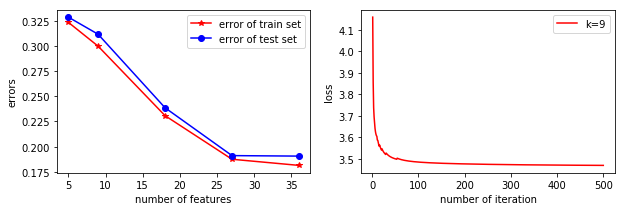

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the results
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(x1['k'], x1['error_train'], 'r-*', label='error of train set')
plt.plot(x1['k'], x1['error_test'], 'b-o', label='error of test set')
plt.xlabel('number of features')
plt.ylabel('errors')
plt.legend()

plt.subplot(122)
plt.plot(y1['iteration'], y1['loss'], 'r-', label='k=9')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

# covtype

In [6]:
# Reading in the MADELON data set
X_train = pd.read_csv('covtype\X_train.csv', header = None)
Y_train = pd.read_csv('covtype\Y_train.csv', header = None)

X_test = pd.read_csv('covtype\X_test.csv', header = None)
Y_test = pd.read_csv('covtype\Y_test.csv', header = None)

ks = np.array([5, 9, 18, 27, 36])
error_results = np.array(np.zeros((ks.size,3)))
ws = np.array(np.zeros((ks.size,2)))

m,n = X_train.shape
m1,n1 = X_test.shape
#normalize the train and validation data sets.
X_train = preprocessing.scale(X_train)
X_train = np.concatenate((np.ones((m,1)), X_train), axis=1)
X_test = preprocessing.scale(X_test)
X_test = np.concatenate((np.ones((m1,1)), X_test), axis=1)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Run FSA
i = 0
for k in ks:
    #X_train, X_valid, Y_train, Y_valid, learning_rate, iteration, eta0, k, print_loss
    if k == 9:
        error_result, loss_10 = fsa(X_train, X_test, Y_train, Y_test, \
                        0.1, 0.001, 500, 100, k, True)
    else :
        error_result, loss = fsa(X_train, X_test, Y_train, Y_test, \
                        0.1, 0.001, 500, 100, k, False)
    error_results[i] = error_result
    i += 1

x2 = pd.DataFrame(data = error_results, columns = ['k',\
                                'error_train', 'error_test'])
y2 = pd.DataFrame(data = loss_10, columns = ['iteration', 'loss'])

x2

,k,error_train,error_test
0,5.0,0.649537,0.592617
1,9.0,0.608730,0.597026
2,18.0,0.486310,0.643192
3,27.0,0.438889,0.669748
4,36.0,0.434788,0.662754


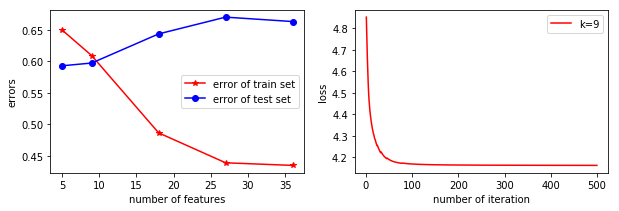

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot the results
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(x2['k'], x2['error_train'], 'r-*', label='error of train set')
plt.plot(x2['k'], x2['error_test'], 'b-o', label='error of test set')
plt.xlabel('number of features')
plt.ylabel('errors')
plt.legend()

plt.subplot(122)
plt.plot(y2['iteration'], y2['loss'], 'r-', label='k=9')
plt.xlabel('number of iteration')
plt.ylabel('loss')
plt.legend()
plt.show()
